In [6]:
import numpy as np
import pandas as pd
import regex as re
from collections import defaultdict,Counter
from scipy.sparse import csr_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns



In [7]:
train_df = pd.read_csv(r"C:\Users\nuzha\Downloads\SI 630\hw1\train (1).csv")
test_df = pd.read_csv(r"C:\Users\nuzha\Downloads\SI 630\hw1\dev.csv")  
test_df['text'] = test_df['text'].fillna("")

train_df.head()

,text,par_id,label
0,"We 're living in times of absolute insanity , ...",1,0
1,"In Libya today , there are countless number of...",2,0
2,White House press secretary Sean Spicer said t...,3,0
3,Council customers only signs would be displaye...,4,0
4,""" Just like we received migrants fleeing El Sa...",5,0


In [8]:
def generate_ngrams(tokens, n):
    """Generate n-grams from a list of tokens."""
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

## 1

In [9]:
def tokenize(text):
    """Tokenize text."""
    return text.strip().split() 

## 2

In [10]:

def better_tokenize(text):
    """Tokenizes text into unigrams, bigrams, and trigrams."""
    if isinstance(text, str):
        stop_words = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
                      'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 
                      'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
                      "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 
                      'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 
                      'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 
                      'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
                      'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
                      'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
                      'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 
                      'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
                      'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 
                      'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
                      'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 
                      'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 
                      're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', 
                      "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', 
                      "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 
                      'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', 
                      "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}

        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s']", "", text)  # Remove punctuation
        text = re.sub(r"\s+", " ", text)  # Normalize spaces
        tokens = text.strip().split()
        tokens = [word for word in tokens if word not in stop_words]  # Remove stop words

        bigrams = generate_ngrams(tokens, 2)
        trigrams = generate_ngrams(tokens, 3)
        
        return tokens + bigrams + trigrams  # Return unigrams, bigrams, and trigrams
    return []


train_df['tokenized'] = train_df['text'].apply(better_tokenize)
test_df['tokenized'] = test_df['text'].apply(better_tokenize)

The better_tokenize function is the updated version for question 2. It makes text lowercase and removes punctuation and extra spaces. It filters out common stop words. It also creates unigrams, bigrams, and trigrams to capture word patterns. These changes make the tokenization cleaner and more useful for analysis.

In [11]:
def vocabulary(data, min_freq=2):
    """Creates vocabulary with words occurring at least min_freq times."""
    word_counts = defaultdict(int)
    for text in data:
        for word in set(text):  
            word_counts[word] += 1
            
    vocab = {}
    current_idx = 0
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = current_idx
            current_idx += 1
    
    return vocab

vocab = vocabulary(train_df['tokenized'], min_freq=2)  

## 3

In [18]:
def create_sparse_matrix(doc, vocab):

    rows, cols, data = [], [], []
    max_vocab_size = len(vocab)  

    for i, tokens in enumerate(doc):
        word_freq = Counter(tokens)
        for word, freq in word_freq.items():
            if word in vocab: 
                col_index = vocab[word] 

                if col_index < max_vocab_size:  # Prevent out-of-bounds errors
                    rows.append(i)
                    cols.append(col_index)
                    data.append(freq)

    return csr_matrix((data, (rows, cols)), shape=(len(doc), max_vocab_size))


# Convert Data to Matrices
X_train = create_sparse_matrix(train_df['tokenized'], vocab)
y_train = train_df['label'].values
X_test = create_sparse_matrix(test_df['tokenized'], vocab)
y_test = test_df['label'].values



## 4

In [19]:
def sigmoid_function(z):
    return 1 / (1 + np.exp(-z))

## 5

In [20]:
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum(target * scores - np.log(1 + np.exp(scores)))
    return ll

# 6

In [21]:
def compute_gradient(X_i, y_i, beta):

    y_hat = sigmoid_function(np.dot(X_i, beta))  
    gradient = (y_hat - y_i) * X_i  
    return gradient

def logistic_regression(X, y, learning_rate=0.01, num_steps=1000):

    if isinstance(X, csr_matrix): # Convert sparse matrix to dense array
        X = X.toarray() 
    y = y.reshape(-1, 1) # Reshape to column vector
    X = np.hstack([np.ones((X.shape[0], 1)), X]) 

    num_features = X.shape[1]
    beta = np.zeros(num_features)  
    log_likelihoods = []

    for step in range(num_steps):
        i = np.random.randint(0, X.shape[0])  
        X_i = X[i]  
        y_i = y[i]  

        
        gradient = compute_gradient(X_i, y_i, beta)
        beta -= learning_rate * gradient  

        if step % 20 == 0:
            ll = log_likelihood(X, y, beta)
            log_likelihoods.append(ll)
            print(f"Step {step}/{num_steps}, Log-Likelihood: {ll:.4f}")

    return beta, log_likelihoods


## 7

In [22]:
def predict(X, beta, threshold=0.2):

    probabilities = sigmoid_function(X.dot(beta))
    return (probabilities >= threshold).astype(int)

## 8

Step 0/1000, Log-Likelihood: -37222769.1838
Step 20/1000, Log-Likelihood: -37210576.9902
Step 40/1000, Log-Likelihood: -37197489.3930
Step 60/1000, Log-Likelihood: -37183661.4378
Step 80/1000, Log-Likelihood: -37168498.6506
Step 100/1000, Log-Likelihood: -37152923.0982
Step 120/1000, Log-Likelihood: -37139975.6618
Step 140/1000, Log-Likelihood: -37123791.3382
Step 160/1000, Log-Likelihood: -37111681.0147
Step 180/1000, Log-Likelihood: -37093100.6737
Step 200/1000, Log-Likelihood: -37081534.1270
Step 220/1000, Log-Likelihood: -37068010.3584
Step 240/1000, Log-Likelihood: -37056817.8094
Step 260/1000, Log-Likelihood: -37044591.0246
Step 280/1000, Log-Likelihood: -37025675.7149
Step 300/1000, Log-Likelihood: -37014131.1151
Step 320/1000, Log-Likelihood: -36997411.5150
Step 340/1000, Log-Likelihood: -36983264.1958
Step 360/1000, Log-Likelihood: -36972903.2776
Step 380/1000, Log-Likelihood: -36962690.8607
Step 400/1000, Log-Likelihood: -36952886.2106
Step 420/1000, Log-Likelihood: -36934844

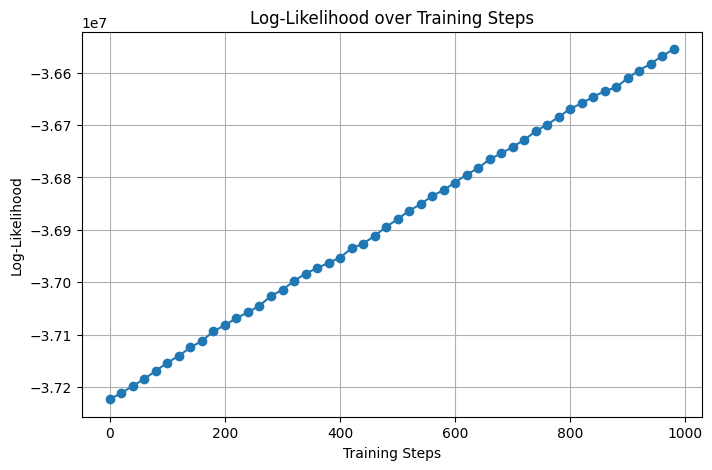

In [23]:
learning_rate = 5e-5
num_steps = 1000


beta, log_likelihoods = logistic_regression(X_train, y_train, learning_rate=learning_rate, num_steps=num_steps)

# Plot Log-Likelihood over Steps
x_values = list(range(0, num_steps, 20))

plt.figure(figsize=(8, 5))
plt.plot(x_values, log_likelihoods, marker='o', linestyle='-')
plt.xlabel("Training Steps")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood over Training Steps")
plt.grid(True)
plt.show()

From the graph, the log-likelihood seems to steadily increase without dramatic fluctuations. The convergence happens when the log-likelihood values remain stable (change rate approaches zero). So, it is not convering

## 9

In [36]:
def logistic_regression_improvised(X, y, X_val, y_val, learning_rate=0.01, steps=8000, reg_lambda=0.001):

    y = y.reshape(-1, 1)  

    if isinstance(X, csr_matrix):  
        X = X.toarray()
    if isinstance(X_val, csr_matrix):  
        X_val = X_val.toarray()

    X = np.hstack([np.ones((X.shape[0], 1)), X])  
    X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])  

    num_features = X.shape[1]
    beta = np.zeros(num_features)  
    log_likelihoods = []

    for step in range(steps):
        i = np.random.randint(0, X.shape[0])  
        X_i = X[i]
        y_i = y[i]

        predictions = sigmoid_function(np.dot(X_i, beta))

        grad = (predictions - y_i) * X_i + reg_lambda * beta

        grad[0] -= reg_lambda * beta[0] # to not regularize bias term

        beta -= learning_rate * grad  

        if step % 100 == 0:
            ll = log_likelihood(X, y, beta) - (reg_lambda / 2) * np.sum(beta ** 2)  # L2 penalty
            log_likelihoods.append(ll)
            print(f"Step {step}/{steps}, Log-Likelihood: {ll:.4f}")

    y_val_pred = predict(X_val, beta)

    TP = np.sum((y_val == 1) & (y_val_pred == 1))
    TN = np.sum((y_val == 0) & (y_val_pred == 0))
    FP = np.sum((y_val == 0) & (y_val_pred == 1))
    FN = np.sum((y_val == 1) & (y_val_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }

    print(f"\nFinal Validation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return beta, log_likelihoods, metrics




Step 0/8000, Log-Likelihood: -37081275.1614
Step 100/8000, Log-Likelihood: -28112105.2858
Step 200/8000, Log-Likelihood: -23366393.2838
Step 300/8000, Log-Likelihood: -21063121.7601
Step 400/8000, Log-Likelihood: -20177622.5691
Step 500/8000, Log-Likelihood: -19465279.9376
Step 600/8000, Log-Likelihood: -18705312.6826
Step 700/8000, Log-Likelihood: -18432149.0941
Step 800/8000, Log-Likelihood: -18219794.3644
Step 900/8000, Log-Likelihood: -18213825.1862
Step 1000/8000, Log-Likelihood: -17953132.7626
Step 1100/8000, Log-Likelihood: -17856632.0923
Step 1200/8000, Log-Likelihood: -17744874.3528
Step 1300/8000, Log-Likelihood: -17680595.6289
Step 1400/8000, Log-Likelihood: -17526352.8936
Step 1500/8000, Log-Likelihood: -17482056.9113
Step 1600/8000, Log-Likelihood: -17559199.7672
Step 1700/8000, Log-Likelihood: -17480735.7723
Step 1800/8000, Log-Likelihood: -17573767.1864
Step 1900/8000, Log-Likelihood: -17575087.4338
Step 2000/8000, Log-Likelihood: -17489431.0158
Step 2100/8000, Log-Likel

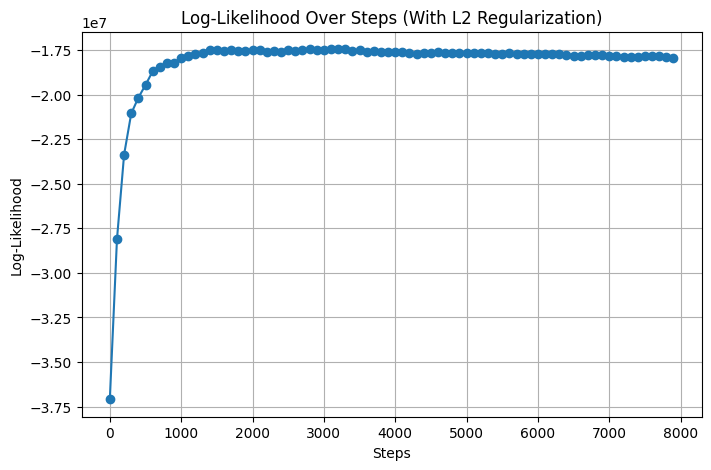

In [39]:
learning_rate = 0.01
steps = 8000
reg_lambda = 0.001 # Regularization strength

beta, log_likelihoods, metrics = logistic_regression_improvised(
    X_train, 
    y_train, 
    X_test.toarray(), 
    y_test, 
    learning_rate=learning_rate, 
    steps=steps,
    reg_lambda=reg_lambda
)

# Plot Log-Likelihood
plt.figure(figsize=(8, 5))
plt.plot(range(0, steps, 100), log_likelihoods, marker='o', linestyle='-')
plt.xlabel("Steps")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood Over Steps (With L2 Regularization)")
plt.grid(True)
plt.show()


The graph shows the log-likelihood values over 8000 training steps for the logistic regression model with L2 regularization.

Parameters:
Learning Rate: 0.01
Steps: 8000
Regularization Strength (L2): 0.001

The log-likelihood increases rapidly at the beginning, indicating significant learning, and then stabilizes as the model converges. This stability suggests that the model has learned effectively and is no longer improving significantly with additional steps.

## 10

In [ ]:
test_data = pd.read_csv(r"C:\Users\nuzha\Downloads\SI 630\hw1\test.student.csv")
test_data['text'] = test_data['text'].fillna("")
test_data['tokenized'] = test_data['text'].apply(better_tokenize)

X_test_final = create_sparse_matrix(test_data['tokenized'], vocab)

X_test_final = X_test_final.toarray()  
X_test_final = np.hstack([np.ones((X_test_final.shape[0], 1)), X_test_final])  

test_predictions = predict(X_test_final, beta)

submission = pd.DataFrame({
    "id": test_data["par_id"],  
    "label": test_predictions.flatten()
})


submission.to_csv("logistic_regression_submission.csv", index=False)
print("Predictions saved to logistic_regression_submission.csv")



Predictions saved to logistic_regression_submission.csv


Kaggle id : Nuzhat Z.
Accuracy: ~ 90%

![Sample Image](1.png "This is a local image")
